# **Day4 실습에 오신것을 환영합니다**




이번 시간에 실습해볼 주제는 Image captioning입니다.


Image captioning은 이미지를 입력으로 넣었을 때 어울리는 문장을 만들어내는 것을 말합니다.

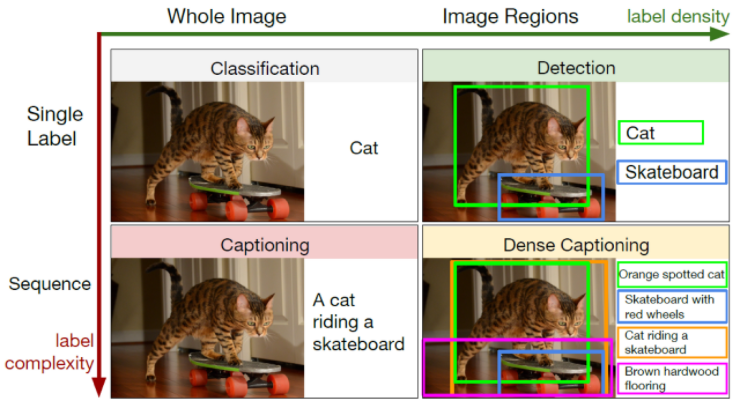

사진 출처 : https://www.edwith.org/deeplearningchoi/lecture/15583?isDesc=false



위 사진과 같이 이미지로부터 적절한 캡션을 출력하는 모델을 구성하는 것이 오늘의 목표입니다.

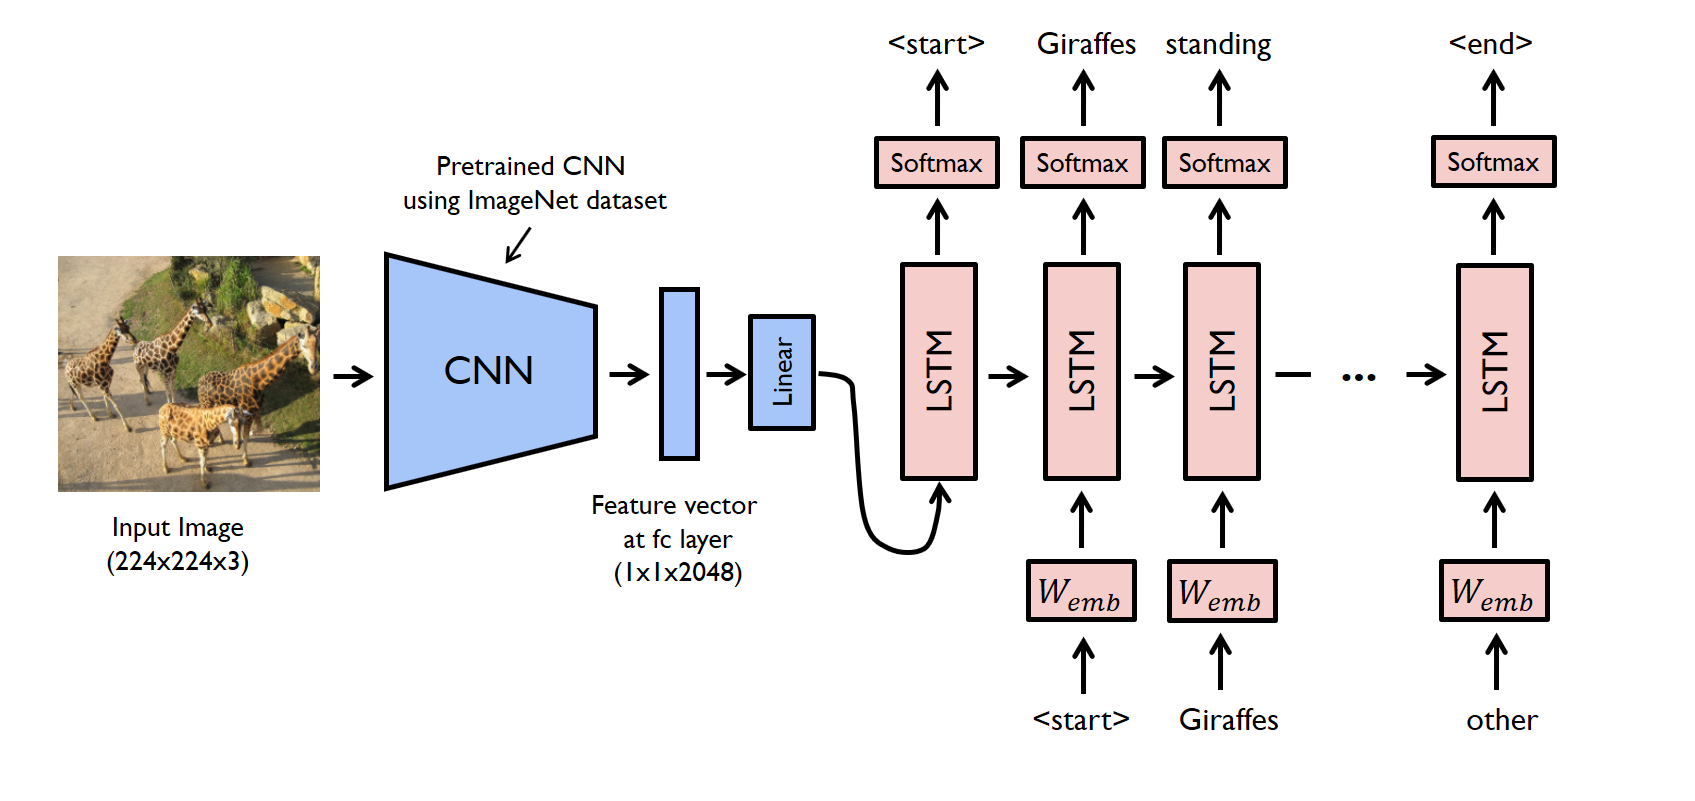

전체적인 구조는 위와 같습니다.


- 미리 학습된 CNN모델은 사물의 종류와 질감, 관계 등 다양한 시각적 의미가 담긴 Feature vector를 추출할 수 있습니다. 이 Feature vector는 디코더의 첫 입력이 됩니다.

- 디코더는 이미지의 Feature vector와 현재까지의 Word embedding으로부터 적절한 다음 단어를 예측하는 방식으로 문장을 구성합니다.

\\

참조) LSTM은 강의에서 배운 RNN의 gradient vanishing 문제를 개선한 모델입니다. 상세한 작동원리가 궁금하다면 다음의 링크를 공부해보세요!
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

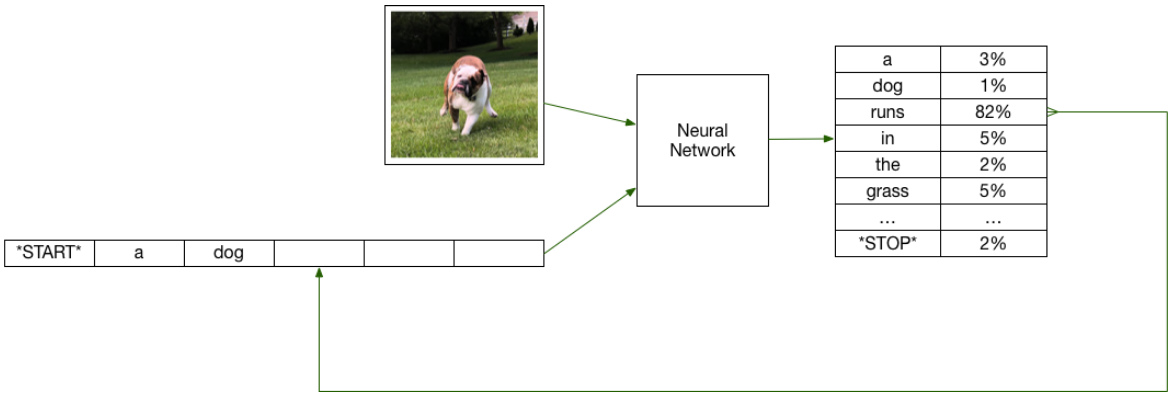

사진 출처 : https://bsnn.tistory.com/45

위의 예시와 같이 입력 이미지와 '현재까지 예측한 문장'(word embedding으로 구성됨)을 바탕으로 적절한 다음 단어를 예측하게 됩니다.

Word embedding과 관련된 것은 Day5에서 실습을 통해 자세히 알아볼 예정입니다. \\
궁금하신 분은 하단의 유튜브 영상을 먼저 보셔도 도움이 될 것 같습니다.

https://www.youtube.com/watch?v=sY4YyacSsLc&t=3s&ab_channel=MinsukHeo%ED%97%88%EB%AF%BC%EC%84%9D

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#<models>
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

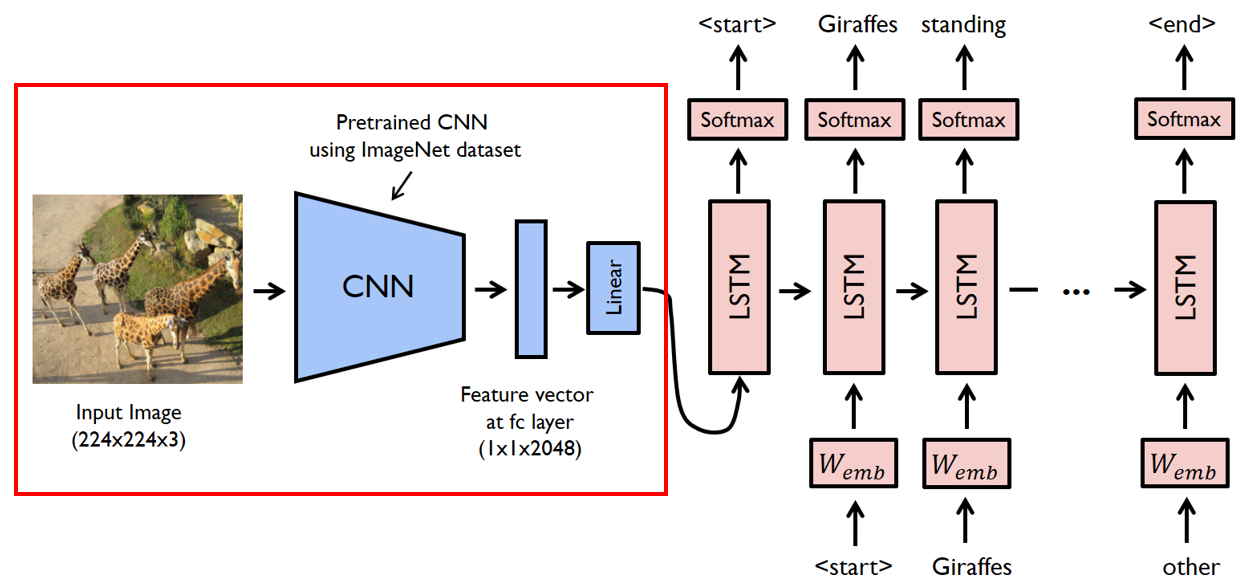

CNN Encoder를 통해 feature를 뽑아내는 모델을 만들어 봅시다.  \\

Pre-trained resnet-152 model을 활용합니다.

In [3]:
#문제
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # [Do it yourself] 학습이 완료된 ResNet-152에서 fully connected layer의 가장 마지막 layer를 제거합니다.
        # Hint: https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch
        # Pretrained 된 모델에서 feature을 뽑을 때 흔히 사용하는 방법입니다.
        # 링크에서 등장하는 asterisk(*)는 Unpacking 하여 layer별로 분리하는 역할을 담당합니다

        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # 마지막 layer를 제거한 resnet에서 뽑아낸 feature를 fully connected layer를 붙여 embed_size vector가 출력이 되도록 합니다.
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # [Do it yourself] LSTM에 넣어줄 input은 vector형태이므로 1D Batch normalization을 해줍니다.(momentum은 0.01로 해주세요)
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)

    def forward(self, images):
        # 입력 이미지로부터 feature vector를 뽑아냅니다
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

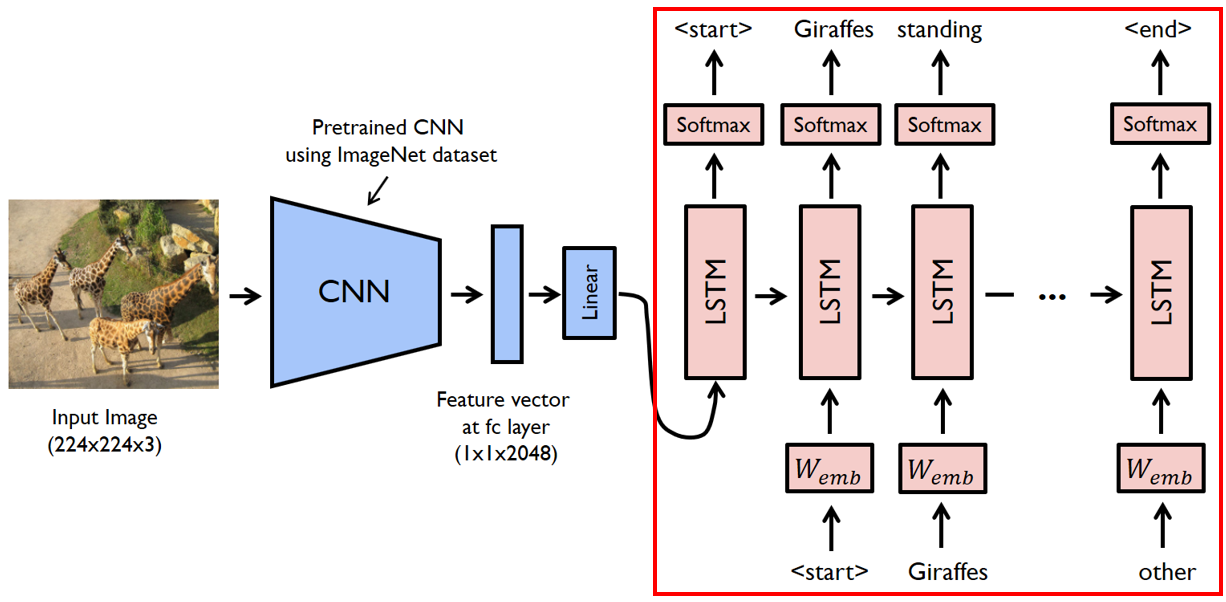

이번에는 LSTM Decoder를 만들어보도록 하겠습니다.

Word embedding과 관련된 것은 주어진 링크를 참조하세요

In [4]:
#문제
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()

        # [Do it yourself] 단어의 개수(vocab_size)와 단어를 표현할 벡터의 차원크기(embed_size)를 입력으로 받아 참조 테이블을 만듭니다.
        # 자세한 것은 아래의 링크를 읽어보세요 (nn.Embedding관련)
        # 1번링크 : https://tutorials.pytorch.kr/beginner/nlp/word_embeddings_tutorial.html
        # 2번링크 : https://wikidocs.net/64779
        self.embed = nn.Embedding(vocab_size,embed_size)

        # [Do it yourself] LSTM layer를 구성해봅시다.
        # https://sanghyu.tistory.com/52
        # 해당 링크에 등장하는 nn.LSTM의 입력 파라미터 중 input_size, hidden_size, num_layers, batch_first가
        # 현재 상황에서는 어떤 변수들과 매칭이 되는지 판단하여 넣어주세요
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers,batch_first=True)

        # [Do it yourself] fully connected layer를 거쳐 어떤 많은 단어들 중 어떤 단어가 뒤에 오면 좋을지 판단해야 하므로
        # 단어의 개수(vocab_size)가 출력의 dimension이 됩니다.
        self.linear = nn.Linear(hidden_size, vocab_size)

        # 문장 안의 단어 sequence의 최대 길이 제한을 위함
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):

        # Image feature vector들을 Decoding 하고 caption들을 생성합니다
        # 현재까지 생성한 captions를 Embedding한 후 이미지 feature와 concat 시켜 다시 입력으로 넣습니다.
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        #pack_padded_sequence는 lstm의 input parameter들을 묶어주는 역할을 합니다.
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)

        # lstm의 출력은 https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html 을 참고하세요!
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])

        return outputs

    def sample(self, features, states=None):
        # 학습이 완료된 상태에서 이미지만 넣었을때 문장이 나오도록 해봅시다
        # 주어진 image feature들을 greedy search방법으로 caption들을 생성합니다.
        # Greedy search란? - https://ko.wikipedia.org/wiki/%ED%83%90%EC%9A%95_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98

        sampled_ids = []
        inputs = features.unsqueeze(1)                           # (1, 256) -> (1, 1, 256)
        for i in range(self.max_seg_length):
            # [Do it yourself] 이미지에서 추출한 feature(inputs)를 input으로 우선 넣은 후 연관성이 높은 단어를 예측합니다.(이때의 lstm의 입력 states = None입니다.)
            # 이때의 출력 states에는 tuple 형태로 2가지를 담고 있습니다. states = (hidden state의 상태, cell state의 상태)이것과 출력으로 나온 단어를
            # 통해 다음에 나올 적절한 단어를 예측하게 됩니다.
            # 하단의 ?에 들어가면 좋을 변수들을 선정하여 채워주세요 (힌트 : LSTM은 출력을 다시 입력으로 받으며, 기존의 상태는 states에 저장합니다.)
            hiddens, states = self.lstm(inputs, states)                    # hiddens: (batch_size, 1, hidden_size) == (1, 1, 512)
                                                                 # states: ([1,1,512], [1,1,512])

            # Hidden layer의 결과를 Fully connected layer를 통해 가장 큰 값을 가지는 단어를 추정합니다.
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size) == (1, 9956)

            # [Do it yourself] 수천개의 단어들 중에서 가장 큰 값을 가지는 단어의 argmax 위치만 필요합니다. 출력에서 max값을 가지는 위치를 뽑아주세요.
            # 자세한 사항은 다음을 참고하세요 https://wikidocs.net/52460 (힌트 : max를 이용하고 적당한 axis를 찾아주세요)
            _, predicted = outputs.max(1)                                     # predicted: (batch_size)

            # [Do it yourself] argmax위치의 단어(predicted)를 기존에 선택된 단어집(sampled_ids)에 추가(append 함수 이용)
            sampled_ids.append(predicted)

            # 현재 만들어진 단어를 기반으로 다음 단어 예측을 위해 워드임베딩을 하여 다음 input으로 넣어줄 준비를 합니다.
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size) == (1, 256)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [5]:
!mkdir data
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
!unzip ./data/captions_train-val2014.zip -d ./data/
!rm  ./data/captions_train-val2014.zip


--2023-06-17 17:34:22--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 20.60.195.163
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|20.60.195.163|:80... connected.
HTTP request sent, awaiting response... 409 Public access is not permitted on this storage account.
2023-06-17 17:34:23 ERROR 409: Public access is not permitted on this storage account..

unzip:  cannot find or open ./data/captions_train-val2014.zip, ./data/captions_train-val2014.zip.zip or ./data/captions_train-val2014.zip.ZIP.
rm: cannot remove './data/captions_train-val2014.zip': No such file or directory


In [6]:
#<build_vocab>
import nltk
nltk.download('punkt')
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import sys
sys.argv=['']
del sys

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [8]:
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # Word의 등장 빈도가 일정 수준('threshold')이하일 경우 버림
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # 문장의 처음과 끝 등..의 special token들을 추가
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # vocabulary에 word들 추가
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [9]:
def main(args):
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
    vocab_path = args.vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

In [10]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--caption_path', type=str, default='./data/annotations/captions_train2014.json', help='path for train annotation file')
    parser.add_argument('--vocab_path', type=str, default='./data/vocab.pkl', help='path for saving vocabulary wrapper')
    parser.add_argument('--threshold', type=int, default=4, help='minimum word count threshold')
    args = parser.parse_args()
    main(args)

loading annotations into memory...


FileNotFoundError: ignored

이번 시간에 필요한 것들은 하단의 링크에서 모두 다운받으실 수 있습니다.


모두 다운받아 내 드라이브 > Colab notebooks > Day4 > materials 디렉토리를 생성하여 파일들을 저장해주세요

(원하는 위치에 파일들을 위치하셔도 무방합니다!)

https://drive.google.com/drive/folders/1uMnJGs5GPpqvZYHT8pcZJZ5kyOXEl7zx?usp=sharing

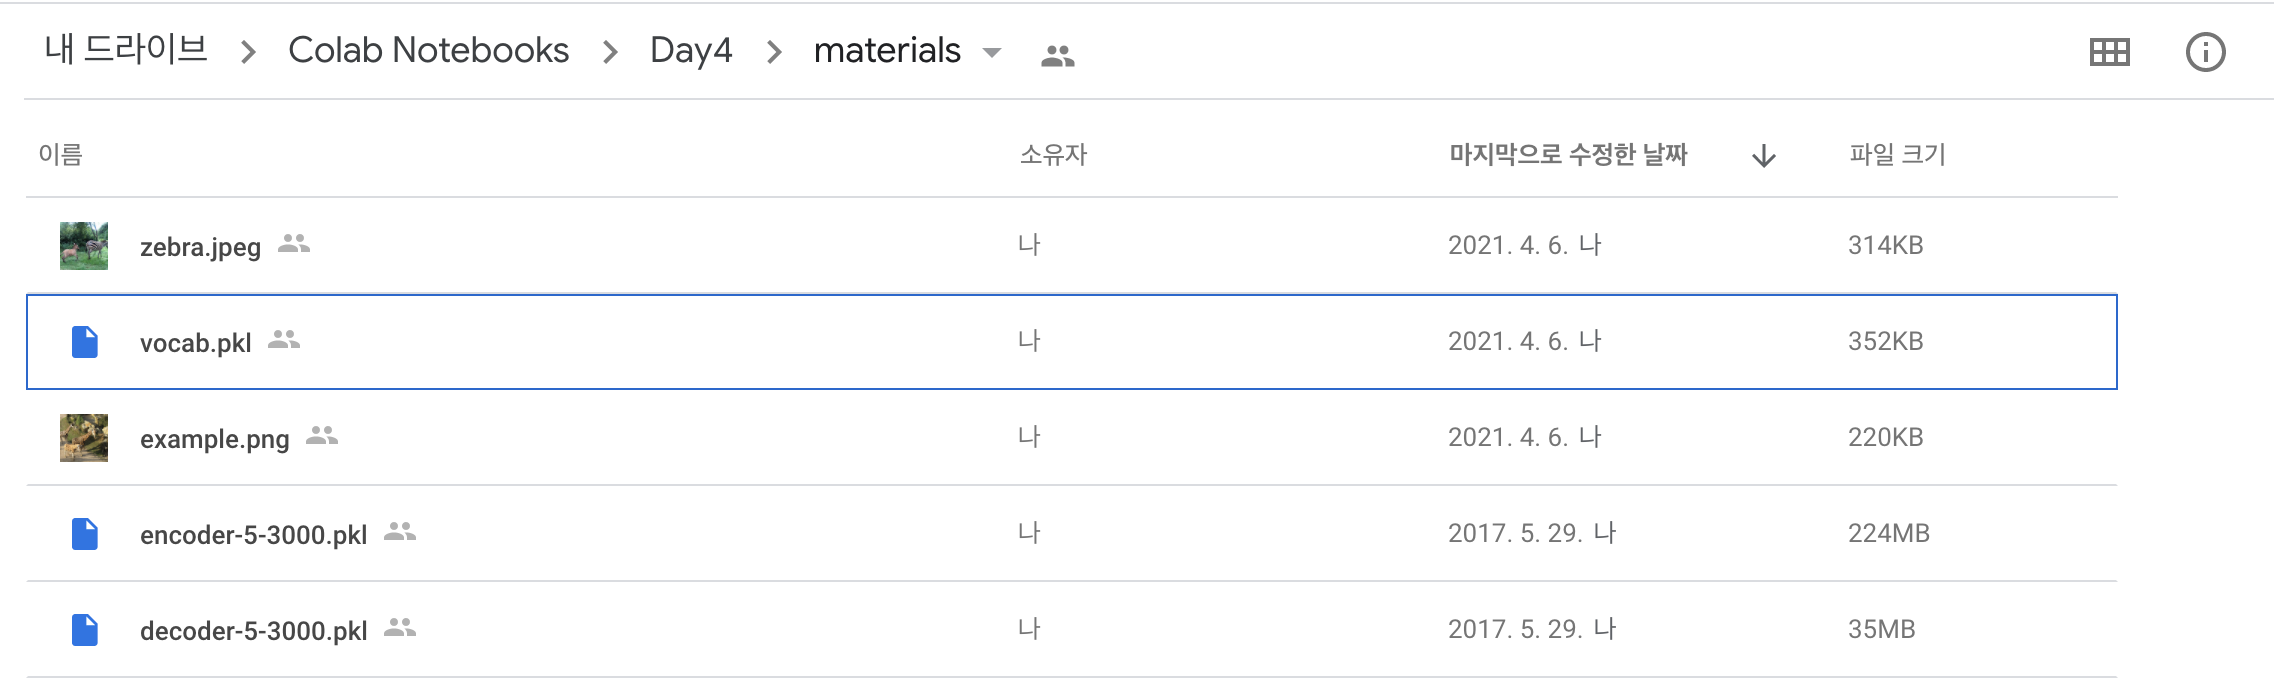

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 67.4MB/s]


<start> a zebra is standing in a field with a tree . <end>


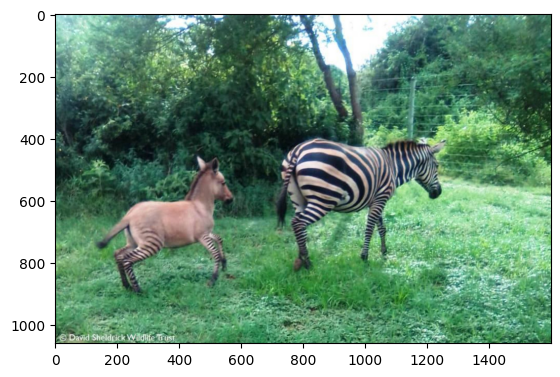

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#임의의 이미지를 넣어도 224x224로 변환합니다.
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

def main():
    """image_input에는 본인이 원하는 동물의 이미지를 다운 받아 입력으로 넣어보면서 어떤 결과가 나오는지 확인하여 봅시다."""
    image_input = '/content/drive/My Drive/Colab Notebooks/Day4/materials/zebra.jpeg'

    encoder_path = '/content/drive/My Drive/Colab Notebooks/Day4/materials/encoder-5-3000.pkl'
    decoder_path = '/content/drive/My Drive/Colab Notebooks/Day4/materials/decoder-5-3000.pkl'
    vocab_path = '/content/drive/My Drive/Colab Notebooks/Day4/materials/vocab.pkl'
    embed_size = 256
    hidden_size = 512
    num_layers = 1

    # 이전에 실습해본 Transform이지만 Normalization과 관련하여 다루지 않았기 때문에 왜 normalization이 필요한지 궁금하다면 하단의 링크를 확인하세요
    # https://89douner.tistory.com/42
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # vocabulary wrapper로 Load
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # model들을 build
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # train이 완료된 모델의 parameter들 로드
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # 입력으로 넣을 image 준비
    image = load_image(image_input, transform)
    image_tensor = image.to(device)

    # image에서 caption생성
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

    # word index에서 words로 변환하여 문장화
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    # 이미지와 캡셔닝 된 문장 결과 출력
    print (sentence)
    image = Image.open(image_input)
    plt.imshow(np.asarray(image))

if __name__ == '__main__':
    main()
